# 讨论如何避免过拟合和欠拟合

## 过拟合
模型在经过多次训练后，准确度达到峰值后停滞或者下降即过拟合

## 欠拟合

测试数据集上仍有改进空间时发生欠拟合

可能的原因：模型不够强，过渡正则化，训练不够

## 探索常见的几种正则化技术 

改进分类模型

In [25]:
import tensorflow as tf 

from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [26]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling 
import tensorflow_docs.plots

In [27]:
from IPython import display
from matplotlib import pyplot as plt

import numpy as np
import pathlib 
import shutil
import tempfile


In [28]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir,ignore_errors=True)

In [29]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [30]:
FEATURES = 28

In [31]:
ds = tf.data.experimental.CsvDataset(gz, [float(),]*(FEATURES+1), compression_type="GZIP")

In [32]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

In [33]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

#批量处理后，再将处理后的数据分开
# .map(pack_row)
# 对批量数据集中的每一批都执行 pack_row 函数
#.map() 函数的核心是对数据集中的每个样本逐一应用自定义的函数，以完成数据的处理和变换。常见应用包括：

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


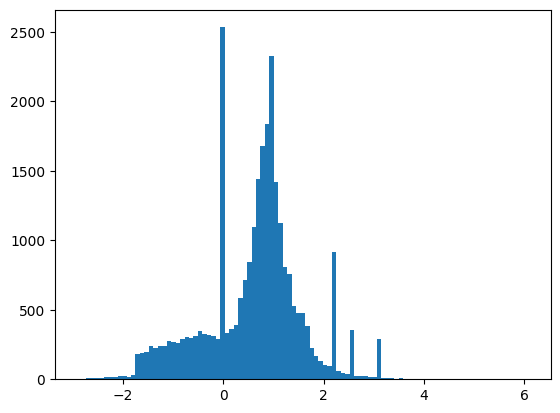

In [34]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

In [35]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [36]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [52]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [38]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

模型的参数越多，“记忆容量”就越大，于是就能够轻松学习训练样本与其目标之间的字典式完美映射（这种映射没有任何泛化能力）

**深度学习模型往往擅长拟合训练数据，但真正的挑战是泛化而非拟合**

In [39]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps = STEPS_PER_EPOCH*1000,
    decay_rate = 1,
    staircase = False)
# tf.keras.optimizers.schedules 随着时间的推移减小学习率：
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

#用于在 1,000 个周期时将学习率根据双曲线的形状降至基础速率的 1/2，在 2,000 个周期时将至 1/3，依此类推。

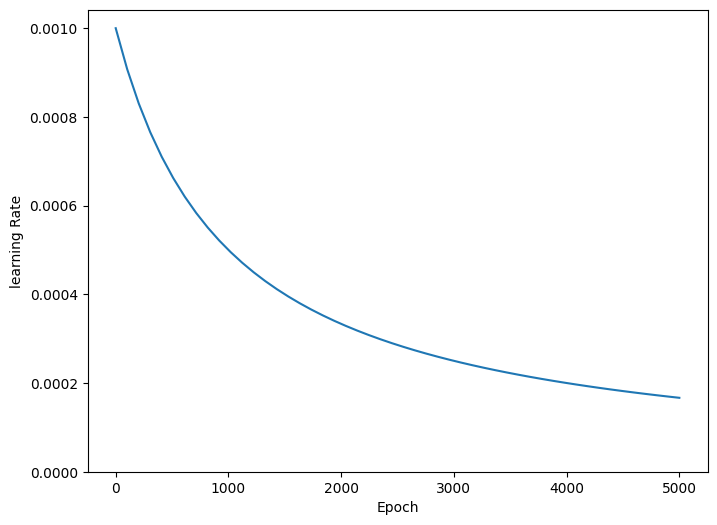

In [40]:
step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')

_ = plt.ylabel('learning Rate') # plt.ylable() 有返回值，一般不用，为了避免输出返回值，使用“_”占位符

In [65]:
def get_callback(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name),
    ]

In [66]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[
                      tf.keras.metrics.BinaryCrossentropy(
                          from_logits=True, name='binary_crossentropy'),'accuracy'])
    model.summary()
    
    history = model.fit(
        train_ds.map(lambda x, y: (x, tf.expand_dims(y, axis=-1))),
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs = max_epochs,
        validation_data=validate_ds.map(lambda x, y: (x, tf.expand_dims(y, axis=-1))), 
        callbacks = get_callback(name),
        verbose=0
    )
    return history
    

In [67]:
tiny_model = tf.keras.Sequential([
    # layers.InputLayer(shape=(None,)),
    layers.Dense(16, activation='relu',
                 input_shape = (FEATURES,)),
    layers.Dense(1)
])

In [68]:
size_histories = {}
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4849,  binary_crossentropy:0.8040,  loss:0.8040,  val_accuracy:0.4640,  val_binary_crossentropy:0.7784,  val_loss:0.7784,  
....................................................................................................
Epoch: 100, accuracy:0.6024,  binary_crossentropy:0.6215,  loss:0.6215,  val_accuracy:0.5660,  val_binary_crossentropy:0.6368,  val_loss:0.6368,  
....................................................................................................
Epoch: 200, accuracy:0.6503,  binary_crossentropy:0.5960,  loss:0.5960,  val_accuracy:0.6080,  val_binary_crossentropy:0.6110,  val_loss:0.6110,  
....................................................................................................
Epoch: 300, accuracy:0.6735,  binary_crossentropy:0.5824,  loss:0.5824,  val_accuracy:0.6250,  val_binary_crossentropy:0.6023,  val_loss:0.6023,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

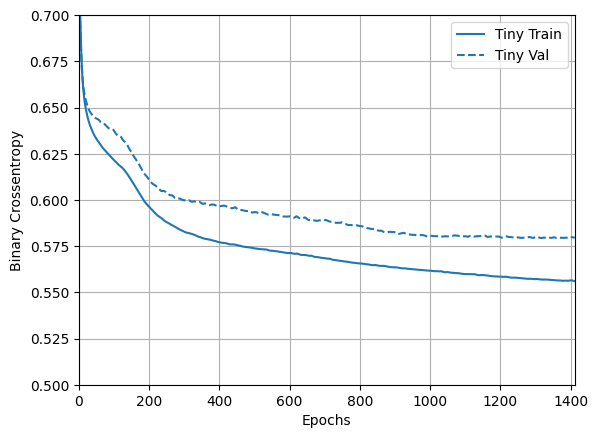

In [71]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])


In [73]:
small_model = tf.keras.Sequential([
    layers.Dense(16, activation = 'elu', input_shape = (FEATURES,)),
    layers.Dense(16, activation = 'elu'),
    layers.Dense(1)
])

d:\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [76]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 753 (2.94 KB)

 Trainable params: 753 (2.94 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.6858,  binary_crossentropy:0.5624,  loss:0.5624,  val_accuracy:0.6770,  val_binary_crossentropy:0.5951,  val_loss:0.5951,  
.

d:\Python\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


...................................................................................................
Epoch: 100, accuracy:0.6960,  binary_crossentropy:0.5578,  loss:0.5578,  val_accuracy:0.6630,  val_binary_crossentropy:0.6001,  val_loss:0.6001,  
....................................................................................................
Epoch: 200, accuracy:0.6960,  binary_crossentropy:0.5532,  loss:0.5532,  val_accuracy:0.6440,  val_binary_crossentropy:0.6082,  val_loss:0.6082,  
...........

In [75]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

d:\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [77]:
size_histories['Medium'] = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,241 (40.00 KB)

 Trainable params: 10,241 (40.00 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4932,  binary_crossentropy:0.6896,  loss:0.6896,  val_accuracy:0.5060,  val_binary_crossentropy:0.6660,  val_loss:0.6660,  
.

d:\Python\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


...................................................................................................
Epoch: 100, accuracy:0.7066,  binary_crossentropy:0.5328,  loss:0.5328,  val_accuracy:0.6700,  val_binary_crossentropy:0.6017,  val_loss:0.6017,  
....................................................................................................
Epoch: 200, accuracy:0.7723,  binary_crossentropy:0.4427,  loss:0.4427,  val_accuracy:0.6440,  val_binary_crossentropy:0.6807,  val_loss:0.6807,  
.....................................................

In [79]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

d:\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [80]:
size_histories['Large'] = compile_and_fit(large_model, "sizes/Large")

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5020,  binary_crossentropy:0.8235,  loss:0.8235,  val_accuracy:0.5000,  val_binary_crossentropy:0.6796,  val_loss:0.6796,  
.

d:\Python\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


...................................................................................................
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0021,  loss:0.0021,  val_accuracy:0.6540,  val_binary_crossentropy:1.7643,  val_loss:1.7643,  
....................................................................................................
Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6530,  val_binary_crossentropy:2.3836,  val_loss:2.3836,  
...............

Text(0.5, 0, 'Epochs [Log Scale]')

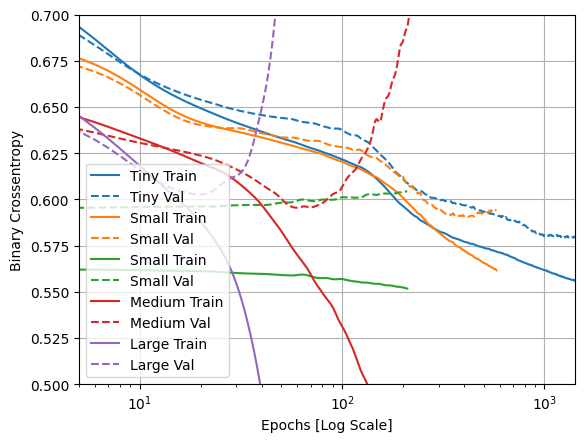

In [82]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [83]:
%load_ext tensorboard

%tensorboard --logdir {logdir}/sizes

In [85]:
#复制Tiny 模型训练日志，用作比较基线
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

WindowsPath('C:/Users/ChenHao/AppData/Local/Temp/tmp2x89wtb2/tensorboard_logs/regularizers/Tiny')

In [86]:
regularizers_histories = {}
regularizers_histories['Tiny'] = size_histories['Tiny']

In [94]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
    
])

d:\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [95]:
regularizers_histories['l2'] = compile_and_fit(l2_model, 'regularizers/l2')

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5134,  binary_crossentropy:0.7858,  loss:2.2968,  val_accuracy:0.4890,  val_binary_crossentropy:0.6885,  val_loss:2.1119,  
.

d:\Python\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


...................................................................................................
Epoch: 100, accuracy:0.6532,  binary_crossentropy:0.5939,  loss:0.6173,  val_accuracy:0.6310,  val_binary_crossentropy:0.5936,  val_loss:0.6172,  
....................................................................................................
Epoch: 200, accuracy:0.6711,  binary_crossentropy:0.5829,  loss:0.6056,  val_accuracy:0.6800,  val_binary_crossentropy:0.5764,  val_loss:0.5992,  
....................................................................................................
Epoch: 300, accuracy:0.6781,  binary_crossentropy:0.5752,  loss:0.5989,  val_accuracy:0.6920,  val_binary_crossentropy:0.5753,  val_loss:0.5989,  
....................................................................................................
Epoch: 400, accuracy:0.6886,  binary_crossentropy:0.5673,  loss:0.5915,  val_accuracy:0.6750,  val_binary_crossentropy:0.5822,  val_loss:0.6064,  
.........

(0.5, 0.7)

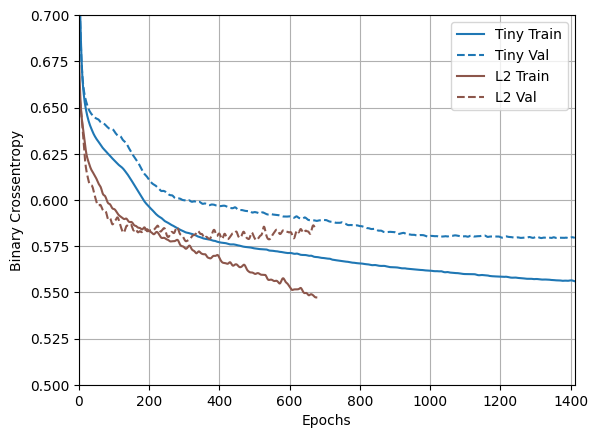

In [96]:
plotter.plot(regularizers_histories)
plt.ylim([0.5, 0.7])

如果您正在编写自己的训练循环，请务必询问模型的正则化损失。

此实现的工作方式是在模型的损失中添加权重惩罚，然后应用标准的优化程序。

In [97]:
result = l2_model(features)
regularizer_loss = tf.add_n(l2_model.losses)

## 添加Dropout

In [98]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

d:\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [99]:
regularizers_histories["dropout"] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5082,  binary_crossentropy:0.7869,  loss:0.7869,  val_accuracy:0.4660,  val_binary_crossentropy:0.6851,  val_loss:0.6851,  
.

d:\Python\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


...................................................................................................
Epoch: 100, accuracy:0.6639,  binary_crossentropy:0.5926,  loss:0.5926,  val_accuracy:0.6840,  val_binary_crossentropy:0.5744,  val_loss:0.5744,  
....................................................................................................
Epoch: 200, accuracy:0.6858,  binary_crossentropy:0.5575,  loss:0.5575,  val_accuracy:0.6700,  val_binary_crossentropy:0.5807,  val_loss:0.5807,  
....................................................................................................
Epoch: 300, accuracy:0.7212,  binary_crossentropy:0.5133,  loss:0.5133,  val_accuracy:0.6760,  val_binary_crossentropy:0.6041,  val_loss:0.6041,  
...................................................

(0.5, 0.7)

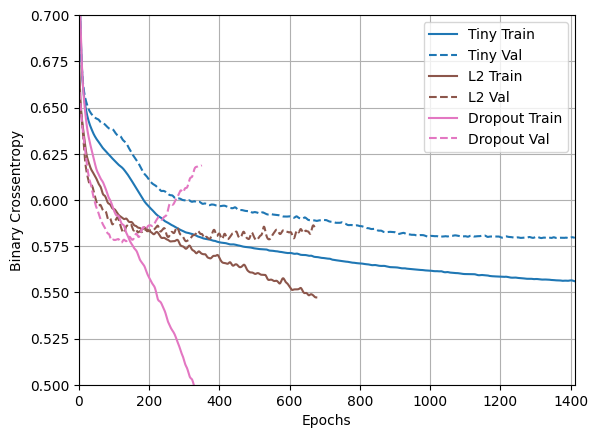

In [100]:
plotter.plot(regularizers_histories)
plt.ylim([0.5, 0.7])

In [101]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1) 
])

d:\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
regularizers_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined") 

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5116,  binary_crossentropy:0.7855,  loss:2.3147,  val_accuracy:0.4900,  val_binary_crossentropy:0.6734,  val_loss:2.1333,  
.

d:\Python\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


...................................................................................................
Epoch: 100, accuracy:0.5732,  binary_crossentropy:0.6431,  loss:0.6548,  val_accuracy:0.5740,  val_binary_crossentropy:0.6309,  val_loss:0.6425,  
....................................................................................................
Epoch: 200, accuracy:0.5736,  binary_crossentropy:0.6436,  loss:0.6541,  val_accuracy:0.5530,  val_binary_crossentropy:0.6331,  val_loss:0.6433,  
....................................................................................................
Epoch: 300, accuracy:0.5714,  binary_crossentropy:0.6440,  loss:0.6541,  val_accuracy:0.5670,  val_binary_crossentropy:0.6299,  val_loss:0.6399,  
...........................................................................

In [ ]:
plotter.plot(regularizers_histories)
plt.ylim([0.5, 0.7])

In [ ]:
%tensorboard --logdir {logdir}/regularizers


防止过拟合常见方式
**获取更多训练数据
降低网络容量 降低网络复杂度
添加权重正则化
添加随机失活**


此外还有**数据增强和批次归一化**两种方法

这些归一化方法可以单独也可以合并使用